# 05.1 All You Need is Regression

**Chapter**: 5 - The Unreasonable Effectiveness of Linear Regression  
**Section**: 1 - All You Need is Regression  
**Facure Source**: 05-The-Unreasonable-Effectiveness-of-Linear-Regression.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-09

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [Potential Outcomes Recap](#11-potential-outcomes-recap)
   - 1.2 [From Means to Regression](#12-from-means-to-regression)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [Regression as Conditional Expectation](#21-regression-as-conditional-expectation)
   - 2.2 [Why Regression Works for RCTs](#22-why-regression-works-for-rcts)
3. [Numeric Demonstration](#3-numeric-demonstration)
   - 3.1 [Online Classroom Example](#31-online-classroom-example)
   - 3.2 [Verifying Coefficient = Difference in Means](#32-verifying-coefficient--difference-in-means)
4. [Implementation](#4-implementation)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm,
    load_facure_data,
    set_notebook_style,
    ols_summary_table,
    create_tufte_figure,
    TUFTE_PALETTE,
)

set_notebook_style()

---

## 1. Facure's Intuition

> **Interview Relevance**: Understanding regression as a causal estimator is foundational. Interviewers test whether you understand *when* regression gives causal estimates vs. mere associations.

### 1.1 Potential Outcomes Recap

As Facure reminds us, each individual has two **potential outcomes**:

- $Y_0$: outcome without treatment
- $Y_1$: outcome with treatment

The **observed outcome** depends on treatment assignment:

$$Y_i = Y_{0i}(1-T_i) + Y_{1i} T_i = Y_{0i} + T_i(Y_{1i} - Y_{0i})$$

The **individual treatment effect** $\tau_i = Y_{1i} - Y_{0i}$ is unknowable—we only see one potential outcome.

So we focus on the **Average Treatment Effect (ATE)**:

$$\text{ATE} = E[Y_1 - Y_0]$$

### 1.2 From Means to Regression

Facure's key insight: if we could simply compare means...

$$E[Y|T=1] - E[Y|T=0] = \underbrace{E[Y_1 - Y_0|T=1]}_{\text{ATT}} + \underbrace{E[Y_0|T=1] - E[Y_0|T=0]}_{\text{BIAS}}$$

The bias term reflects **selection**: treated units may differ from control units even without treatment.

**Randomization eliminates bias**: In an RCT, treatment is independent of potential outcomes, so $E[Y_0|T=1] = E[Y_0|T=0]$.

★ Insight ─────────────────────────────────────
- Regression with treatment dummy recovers the difference in means
- With randomization, this equals the ATE
- Bonus: regression gives standard errors and confidence intervals "for free"
─────────────────────────────────────────────────

---

## 2. Formal Treatment

### 2.1 Regression as Conditional Expectation

Consider the simple regression model:

$$Y_i = \beta_0 + \kappa T_i + u_i$$

where $T_i \in \{0, 1\}$ is a treatment indicator.

**Proposition**: The OLS estimates satisfy:

$$\hat{\beta}_0 = \bar{Y}_0 = \frac{1}{n_0} \sum_{i: T_i=0} Y_i$$

$$\hat{\kappa} = \bar{Y}_1 - \bar{Y}_0$$

**Proof**: With a binary regressor, the OLS coefficient is:

$$\hat{\kappa} = \frac{\text{Cov}(Y, T)}{\text{Var}(T)}$$

For binary $T$ with $P(T=1) = p$:
- $\text{Var}(T) = p(1-p)$
- $\text{Cov}(Y, T) = E[YT] - E[Y]E[T] = p\bar{Y}_1 - (p\bar{Y}_1 + (1-p)\bar{Y}_0)p$

Simplifying:
$$\hat{\kappa} = \frac{p(1-p)(\bar{Y}_1 - \bar{Y}_0)}{p(1-p)} = \bar{Y}_1 - \bar{Y}_0 \quad \blacksquare$$

### 2.2 Why Regression Works for RCTs

**Assumption (Randomization)**: $(Y_0, Y_1) \perp T$

Under randomization:

$$E[\hat{\kappa}] = E[\bar{Y}_1 - \bar{Y}_0] = E[Y_1] - E[Y_0] = \text{ATE}$$

The regression coefficient is an **unbiased estimator** of the ATE.

**Variance**: The Neyman (1923) variance formula for the difference in means:

$$\text{Var}(\hat{\kappa}) = \frac{\sigma_1^2}{n_1} + \frac{\sigma_0^2}{n_0}$$

OLS with heteroskedasticity-robust standard errors recovers this exactly.

---

## 3. Numeric Demonstration

### 3.1 Online Classroom Example

Facure's example: students randomly assigned to online vs. face-to-face instruction.

In [2]:
# Load online classroom data
data = load_facure_data('online_classroom.csv')

# Filter to non-blended formats (pure online vs face-to-face)
data = data.query('format_blended == 0').copy()

print(f"Sample size: n = {len(data)}")
print(f"Treatment: format_ol (1 = online, 0 = face-to-face)")
print(f"Outcome: falsexam (exam score)")
print(f"\nTreatment distribution:")
print(data['format_ol'].value_counts().sort_index())

Sample size: n = 214
Treatment: format_ol (1 = online, 0 = face-to-face)
Outcome: falsexam (exam score)

Treatment distribution:
format_ol
0    120
1     94
Name: count, dtype: int64


In [3]:
# Method 1: Simple difference in means
mean_control = data.query('format_ol == 0')['falsexam'].mean()
mean_treated = data.query('format_ol == 1')['falsexam'].mean()
diff_means = mean_treated - mean_control

print("Method 1: Difference in Means")
print(f"  E[Y|T=0] (face-to-face): {mean_control:.4f}")
print(f"  E[Y|T=1] (online):       {mean_treated:.4f}")
print(f"  Difference:              {diff_means:.4f}")

Method 1: Difference in Means
  E[Y|T=0] (face-to-face): 78.5475
  E[Y|T=1] (online):       73.6353
  Difference:              -4.9122


In [4]:
# Method 2: OLS regression
import statsmodels.formula.api as smf

model = smf.ols('falsexam ~ format_ol', data=data).fit()

print("\nMethod 2: OLS Regression")
print(f"  Intercept (β₀):    {model.params['Intercept']:.4f}")
print(f"  Coefficient (κ):   {model.params['format_ol']:.4f}")
print(f"  95% CI:            [{model.conf_int().loc['format_ol', 0]:.4f}, {model.conf_int().loc['format_ol', 1]:.4f}]")
print(f"  p-value:           {model.pvalues['format_ol']:.4f}")


Method 2: OLS Regression
  Intercept (β₀):    78.5475
  Coefficient (κ):   -4.9122
  95% CI:            [-8.2230, -1.6014]
  p-value:           0.0038


### 3.2 Verifying Coefficient = Difference in Means

In [5]:
# Verify the two methods match exactly
print("VERIFICATION")
print("="*50)
print(f"Intercept = E[Y|T=0]?")
print(f"  {model.params['Intercept']:.10f} = {mean_control:.10f}")
print(f"  Match: {np.isclose(model.params['Intercept'], mean_control)}")
print()
print(f"Coefficient = Difference in means?")
print(f"  {model.params['format_ol']:.10f} = {diff_means:.10f}")
print(f"  Match: {np.isclose(model.params['format_ol'], diff_means)}")

# Assertions for test validation
assert np.isclose(model.params['Intercept'], mean_control, rtol=1e-10)
assert np.isclose(model.params['format_ol'], diff_means, rtol=1e-10)

VERIFICATION
Intercept = E[Y|T=0]?
  78.5474845833 = 78.5474845833
  Match: True

Coefficient = Difference in means?
  -4.9122214982 = -4.9122214982
  Match: True


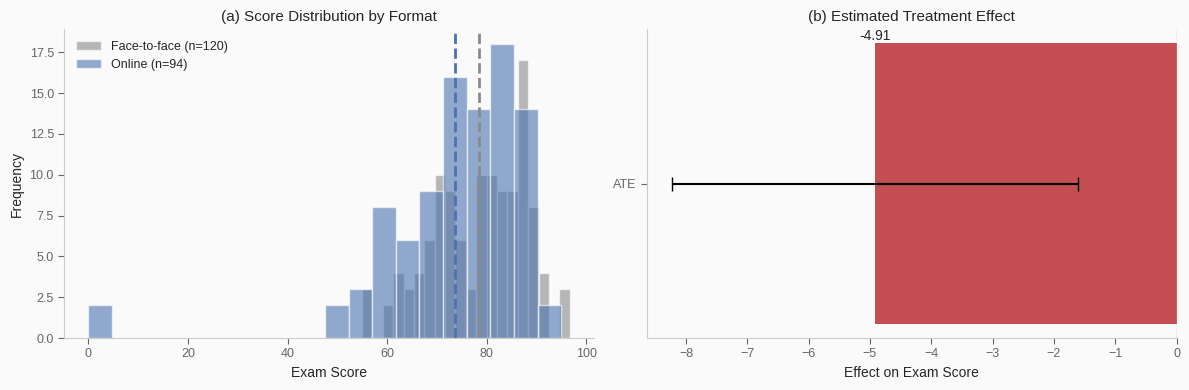

In [6]:
# Visualize the result
fig, axes = create_tufte_figure(1, 2, figsize=(12, 4))

# Panel 1: Distribution by treatment group
ax = axes[0]
for t, label, color in [(0, 'Face-to-face', TUFTE_PALETTE['control']), 
                         (1, 'Online', TUFTE_PALETTE['treatment'])]:
    subset = data.query(f'format_ol == {t}')['falsexam']
    ax.hist(subset, bins=20, alpha=0.6, label=f'{label} (n={len(subset)})', 
            color=color, edgecolor='white')
    ax.axvline(subset.mean(), color=color, linestyle='--', linewidth=2)

ax.set_xlabel('Exam Score')
ax.set_ylabel('Frequency')
ax.set_title('(a) Score Distribution by Format')
ax.legend(frameon=False)

# Panel 2: Treatment effect estimate
ax = axes[1]
ax.barh(['ATE'], [model.params['format_ol']], 
        xerr=[[model.params['format_ol'] - model.conf_int().loc['format_ol', 0]],
              [model.conf_int().loc['format_ol', 1] - model.params['format_ol']]],
        color=TUFTE_PALETTE['effect'], capsize=5, height=0.4)
ax.axvline(0, color=TUFTE_PALETTE['spine'], linestyle='-', linewidth=1)
ax.set_xlabel('Effect on Exam Score')
ax.set_title('(b) Estimated Treatment Effect')
ax.text(model.params['format_ol'], 0.2, f'{model.params["format_ol"]:.2f}', 
        ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

**Interpretation**: Online classes reduce exam scores by about 4.9 points on average. The 95% confidence interval excludes zero, suggesting this effect is statistically significant.

---

## 4. Implementation

The simple ATE estimator via regression is a building block for more sophisticated methods in `causal_inference_mastery`:

```python
# From causal_inference.rct.simple_ate
from causal_inference.rct.simple_ate import simple_ate, ATEResult

result = simple_ate(outcome=data['falsexam'], treatment=data['format_ol'])
print(f"ATE: {result.ate:.4f}")
print(f"SE:  {result.se:.4f}")
print(f"CI:  [{result.ci_lower:.4f}, {result.ci_upper:.4f}]")
```

The production code adds:
- Heteroskedasticity-robust standard errors
- Cluster-robust inference
- Covariate adjustment for efficiency gains

---

## 5. Interview Appendix

### Practice Questions

**Q1 (Meta E5, DS)**: *"Why does regression give us causal estimates in an RCT but not always in observational data?"*

<details>
<summary>Solution</summary>

**Key points:**

1. **Identification vs. estimation**: Regression is an *estimation* technique. Whether it identifies a *causal* effect depends on the data-generating process.

2. **RCT case**: Randomization ensures $(Y_0, Y_1) \perp T$:
   - Treated and control groups have the same distribution of potential outcomes
   - Selection bias = 0
   - $E[Y|T=1] - E[Y|T=0] = E[Y_1] - E[Y_0] = \text{ATE}$

3. **Observational case**: Without randomization, $T$ may depend on $Y_0$:
   - Example: People who choose more education may have higher baseline ability
   - Selection bias $\neq 0$
   - Regression coefficient captures ATE + bias

4. **Fix**: In observational data, add controls for confounders (see Section 03-04). But this requires the "conditional ignorability" assumption—that *all* confounders are observed and controlled.

</details>

---

**Q2 (Google L5, Quant)**: *"Show mathematically that the regression coefficient on a binary treatment equals the difference in means."*

<details>
<summary>Solution</summary>

**Derivation:**

For regression $Y = \beta_0 + \kappa T + u$ with binary $T$:

$$\hat{\kappa} = \frac{\text{Cov}(Y, T)}{\text{Var}(T)}$$

Let $p = P(T=1)$ (treatment probability).

**Variance of T**:
$$\text{Var}(T) = E[T^2] - E[T]^2 = p - p^2 = p(1-p)$$

**Covariance**:
$$\text{Cov}(Y,T) = E[YT] - E[Y]E[T]$$

- $E[YT] = E[Y|T=1]P(T=1) = \bar{Y}_1 \cdot p$
- $E[Y] = \bar{Y}_1 p + \bar{Y}_0(1-p)$
- $E[T] = p$

So:
$$\text{Cov}(Y,T) = \bar{Y}_1 p - [\bar{Y}_1 p + \bar{Y}_0(1-p)]p = p(1-p)(\bar{Y}_1 - \bar{Y}_0)$$

Therefore:
$$\hat{\kappa} = \frac{p(1-p)(\bar{Y}_1 - \bar{Y}_0)}{p(1-p)} = \bar{Y}_1 - \bar{Y}_0$$

</details>

---

**Q3 (Amazon L6, Econ)**: *"What's the advantage of using regression over a simple t-test for A/B testing?"*

<details>
<summary>Solution</summary>

**Advantages of regression:**

1. **Covariate adjustment**: Can add pre-treatment covariates to reduce variance and increase precision (ANCOVA)

2. **Multiple treatments**: Easy to compare >2 groups with dummy variables

3. **Heterogeneous effects**: Can test interactions (e.g., does treatment work differently for men vs women?)

4. **Continuous treatments**: Regression generalizes naturally; t-test is binary only

5. **Standard error flexibility**: Can use robust, clustered, or bootstrap SEs

6. **Model diagnostics**: R², F-tests, residual plots

**Note**: For a simple two-group comparison without covariates, the regression coefficient and t-test give *identical* p-values (they're mathematically equivalent).

</details>

---

## 6. References

[^1]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 5: "All You Need is Regression."

[^2]: Neyman, J. (1923). On the Application of Probability Theory to Agricultural Experiments. *Statistical Science*, 5(4), 465-472 (translated 1990).

[^3]: Angrist, J. D. and Pischke, J.-S. (2009). *Mostly Harmless Econometrics*. Princeton University Press, Chapter 2.

[^4]: Imbens, G. W. and Rubin, D. B. (2015). *Causal Inference for Statistics, Social, and Biomedical Sciences*. Cambridge University Press.

---

**Precision Improvement:**
- You said: "Build the first section notebook"
- Concise: "Build 01_all_you_need_is_regression"
- Precise: `/augmented 05.1 --ate-basics --verify-means`
- Pattern: [build] [target] [content-flags]